In [2]:
from torch_snippets import * 
from torchvision.datasets import MNIST
from torchvision import transforms 
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
    
device

'cuda'

In [3]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]), 
    transforms.Lambda(lambda x: x.to(device))
])

In [12]:

batch_size = 512
train_dataset = MNIST('content/', transform=img_transform, train=True, download=True)
val_dataset = MNIST('content/', transform=img_transform, train=False, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        
        self.encoder = nn.Sequential(
                nn.Linear(28*28, 128), 
                nn.ReLU(True),
                nn.Linear(128, 64),
                nn.ReLU(True),
                nn.Linear(64, latent_dim))
                
        self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 64),
                nn.ReLU(True),
                nn.Linear(64, 128),
                nn.ReLU(True),
                nn.Linear(128, 28*28),
                nn.Tanh())
        
    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [14]:
model = AutoEncoder(3).to(device)

In [15]:
def train_batch(inputs, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [17]:
num_epochs = 10
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(train_dataloader)
    for ix, (data, _) in enumerate(train_dataloader):
        loss = train_batch(data, model, optimizer, criterion)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(train_dataloader)
    for ix, (data, _) in enumerate(val_dataloader):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  trn_loss: 0.316  val_loss: 0.222  (15.04s - 135.34s remaining)
EPOCH: 2.000  trn_loss: 0.204  val_loss: 0.189  (30.10s - 120.41s remaining)
EPOCH: 3.000  trn_loss: 0.181  val_loss: 0.173  (45.14s - 105.32s remaining)
EPOCH: 4.000  trn_loss: 0.169  val_loss: 0.164  (60.09s - 90.14s remaining)
EPOCH: 5.000  trn_loss: 0.162  val_loss: 0.158  (75.07s - 75.07s remaining)
EPOCH: 6.000  trn_loss: 0.156  val_loss: 0.153  (90.15s - 60.10s remaining)
EPOCH: 7.000  trn_loss: 0.152  val_loss: 0.150  (105.15s - 45.06s remaining)
EPOCH: 8.000  trn_loss: 0.149  val_loss: 0.148  (120.19s - 30.05s remaining)
EPOCH: 9.000  trn_loss: 0.147  val_loss: 0.146  (135.19s - 15.02s remaining)
EPOCH: 10.000  trn_loss: 0.145  val_loss: 0.145  (150.16s - 0.00s remaining)


100%|██████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 3220.58it/s]


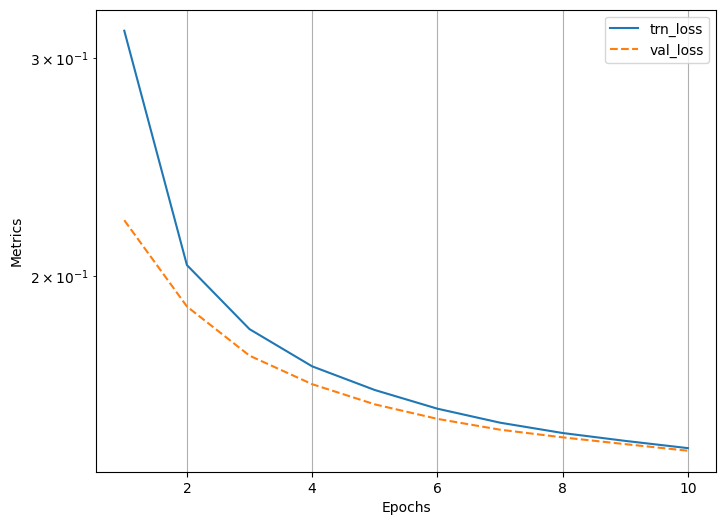

In [18]:
log.plot_epochs(log=True)

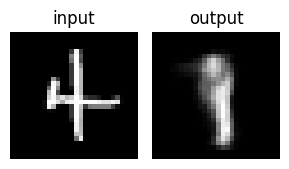

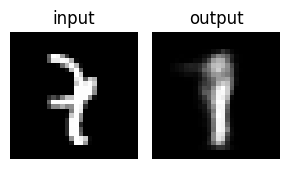

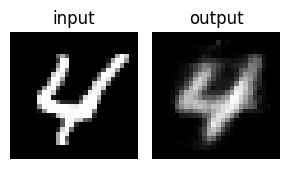

In [22]:
for _ in range(3):
    ix = np.random.randint(len(val_dataset))
    im, _ = val_dataset[ix]
    _im = model(im[None])[0]
    fix, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='output')
    plt.tight_layout()
    plt.show()